In [1]:
from astropy.io import fits
from astropy.wcs import WCS
from astropy import constants as cst
from astropy import units as u
from astropy.cosmology import FlatLambdaCDM
from astropy.cosmology import z_at_value
from astropy.modeling.models import BlackBody
import pandas as pd
import healpy as hp
import numpy as np
import scipy as sp
from sympy import Matrix
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.integrate import fixed_quad
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors as colors
from matplotlib.colors import SymLogNorm
import glob
import os
%pylab inline
pylab.rcParams['figure.figsize'] = (8, 8)
#matplotlib.rcParams.update({'font.size': 17})
matplotlib.rcParams.update({'figure.autolayout': True})

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


#  $\underline{\rm 0- ~Cosmology}$

In [2]:
# Planck cosmo 2018 | TT,TE,EE+lowE+lensing+BAO
h = 0.6898
Om = 0.2905
Ov = 0.7095
sig8 = 0.8260
ns = 0.9690
#Ob_h2 = 0.02242
Ob = 0.0473
#Oc_h2 = 0.11933
#Oc = Oc_h2/h**2
b_ia = 0.5
B_amp = 3.13

In [3]:
omegam_0 = Om
cosmo = FlatLambdaCDM(H0=68.98, Om0=omegam_0,Ob0=0)

In [4]:
cosmo.Om0,cosmo.Ode0,cosmo.Ob0,cosmo.Ogamma0,cosmo.Onu0

(0.2905, 0.7095, 0.0, 0.0, 0.0)

In [5]:
def E(z,omega_m,omega_l):
    E_of_z = np.sqrt(omega_m*(1+z)**3+omega_l)
    return E_of_z

# $\underline{\rm 1- ~Calculate ~the ~BNT ~matrix ~from ~the ~n(z)}$

###  Read the n(z) in bins and calculate $n_i^{(0)}$ and $n_i^{(1)}$

$w_i(\chi)=\frac{3\Omega_0H_0^2}{2c^2} \int_{\rm bin_i}{\rm d}z n(z)\frac{f_K(\chi(z)-\chi)f_K(\chi)}{f_K(\chi(z))}\frac{1}{a(\chi)}$

$n_i^{(0)}=\int_{\rm bin ~i}{\rm d}\chi n(\chi)$

$n_i^{(1)}=\int_{\rm bin ~i}{\rm d}\chi n(\chi)\xi_K(\chi)$

In [6]:
def n_0_i_int(z,n_of_z_interp):
    return n_of_z_interp(z)

def n_1_i_int(z,n_of_z_interp):
    chi_of_z = (cosmo.comoving_distance(z)/(cst.c/cosmo.H0)).cgs
    n_1_i_int = n_of_z_interp(z)/chi_of_z
    return n_1_i_int

### 1-1 With separate n(z) files

,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
1,6.709678,2.757165,2.067182,1.700346,1.45697,1.275822,1.130408,1.005129,0.888099,0.759146


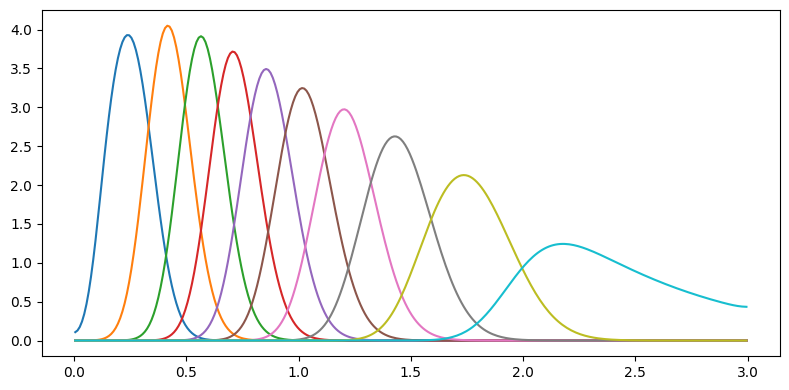

In [129]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

ntomobin = 10
nzrows = 300
nz_table = np.zeros((nzrows,ntomobin+1))

file_path = 'nofz_SLICS_LSST_bin'
n_0 = np.zeros(ntomobin)
n_1 = np.zeros(ntomobin)

for i in range(ntomobin):
    file_data = np.loadtxt(file_path+str(i+1)+'.dat', skiprows=2)
    #z_list = file_data[:,0]
    #f_list = file_data[:,3]
    nz_table[:,0] = file_data[:,0]
    nz_table[:,i+1] = file_data[:,3]
    plt.plot(nz_table[:,0],nz_table[:,i+1])

    n_of_z_interp = interp1d(nz_table[:,0], nz_table[:,i+1], kind='quadratic',fill_value='extrapolate')
    
    zmin=1e-18
    zmax=3
    n_0[i], error = fixed_quad(n_0_i_int, zmin, zmax,args=(n_of_z_interp,),n=10000)
    n_1[i], error = fixed_quad(n_1_i_int, zmin, zmax, args=(n_of_z_interp,),n=10000)
        
pd.DataFrame([n_0,n_1])

### 1-2 All n(z) in one file

,0,1,2,3,4,5,6,7,8,9
0,1.000000,1.000000,1.000000,1.000000,1.00000,1.000000,1.000000,1.000000,1.000000,1.000000
1,6.709678,2.757165,2.067182,1.700346,1.45697,1.275822,1.130408,1.005129,0.888099,0.759146


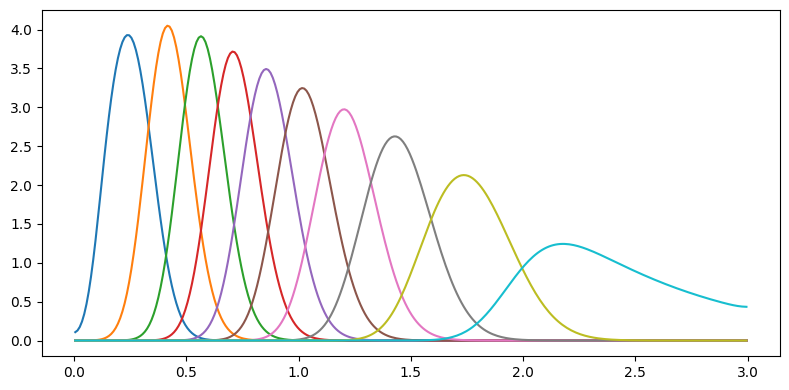

In [7]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

#nz_path = '/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/zdistris/source_lssty1.nz'
nz_path = '/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/zdistris/source_LSST_10bins.dat'
file_data = np.loadtxt(nz_path)

nzrows = file_data.shape[0]
ntomobin = file_data.shape[1]-1

#ntomobin = 5
#nzrows = 300

nz_table = np.zeros((nzrows,ntomobin+1))
n_0 = np.zeros(ntomobin)
n_1 = np.zeros(ntomobin)


for i in range(ntomobin):
    nz_table[:,0] = file_data[:,0]
    nz_table[:,i+1] = file_data[:,i+1]
    
    zmin=1e-18
    zmax=3
    n_of_z_interp = interp1d(nz_table[:,0], nz_table[:,i+1], kind='quadratic',fill_value='extrapolate')
    n_0[i], error = fixed_quad(n_0_i_int, zmin, zmax,args=(n_of_z_interp,),n=10000)
    n_1[i], error = fixed_quad(n_1_i_int, zmin, zmax, args=(n_of_z_interp,),n=10000)       
    
    plt.plot(nz_table[:,0],nz_table[:,i+1])

pd.DataFrame([n_0,n_1])

## Calculate the BNT matrix

In [8]:
p_a_i = np.zeros((ntomobin,ntomobin))
p_a_i[1,0] = -1
for i in range(ntomobin):
    p_a_i[i,i] = 1

In [9]:
for i in range(2,ntomobin):
    print(i)
    p_a_i[i,i-2] = (n_1[i]*n_0[i-1]-n_0[i]*n_1[i-1])/(n_0[i-2]*n_1[i-1]-n_1[i-2]*n_0[i-1])
    p_a_i[i,i-1] = (n_1[i]*n_0[i-2]-n_0[i]*n_1[i-2])/(n_0[i-1]*n_1[i-2]-n_1[i-1]*n_0[i-2])

2
3
4
5
6
7
8
9


In [10]:
Mat_p_a_i = Matrix(p_a_i)
Mat_p_a_i

Matrix([
[              1.0,                 0,                 0,                 0,                 0,                 0,                 0,                 0,                 0,   0],
[             -1.0,               1.0,                 0,                 0,                 0,                 0,                 0,                 0,                 0,   0],
[0.174568273835669, -1.17456833734345,               1.0,                 0,                 0,                 0,                 0,                 0,                 0,   0],
[                0, 0.531660190483591, -1.53166019181256,               1.0,                 0,                 0,                 0,                 0,                 0,   0],
[                0,                 0, 0.663443582465118, -1.66344358238735,               1.0,                 0,                 0,                 0,                 0,   0],
[                0,                 0,                 0, 0.744314547503051, -1.74431454755849,      

In [11]:
p_a_i[3,1]

0.5316601904835908

### Checking unity

In [12]:
Mat_p_a_i_inv = Mat_p_a_i.inv()
Mat_p_a_i_inv*Mat_p_a_i

Matrix([
[                  1.0,                     0,                     0,                     0,                     0,                     0,                    0,                     0,   0,   0],
[-1.11022302462516e-16,                   1.0,                     0,                     0,                     0,                     0,                    0,                     0,   0,   0],
[-1.38777878078145e-16,                     0,                   1.0,                     0,                     0,                     0,                    0,                     0,   0,   0],
[ 1.11022302462516e-16, -2.22044604925031e-16,                     0,                   1.0,                     0,                     0,                    0,                     0,   0,   0],
[-5.55111512312578e-17, -4.44089209850063e-16, -1.11022302462516e-16, -2.22044604925031e-16,                   1.0,                     0,                    0,                     0,   0,   0],
[ 5.551115123125

### Calculate the $P_A^{~~I}$ matrix

$n_{\rm tomo}$ is the number of redshift bins.

$(i,j)$ are pairs of redshift bins. $\xi_{ij}^{+/-}(\theta_k)$ are the tomographic shear correlation functions between redshift bins $i$ and $j$ at scale $\theta_k$.

$p_{ai}$ is the BNT matrix. Its size is $n_{\rm tomo} \times n_{\rm tomo}$.

The BNT transform $\xi\rightarrow\hat\xi$ is:
<div style="text-align: center">
$\hat \xi_{ab}^{+/-}(\theta_k) = \sum_{ij} p_{ai}p_{bj}\xi_{ij}^{+/-}(\theta_k)$
</div>

The number of distincts $(i,j)$ pairs is $\frac{n_{\rm tomo}(1+n_{\rm tomo})}{2}$.

Ordering before BNT:

**inner loop is over tomo bin pairs**

**intermediate loop is over $\theta_k$ scales**

**outer loop is over** $+$ **and** $-$

<div style="text-align: center">
$V_{I}=\begin{pmatrix}
    \begin{array}{cc}
        \begin{bmatrix}
        . \\
        . \\
       \end{bmatrix} \rm ij's & \xi^+ (\theta_0) \\
       \begin{array}{c}
        &&&. \\
        &&&. \\
       \end{array} \\
       \begin{bmatrix}
        . \\
        . \\
       \end{bmatrix} \rm ij's & \xi^+ (\theta_n) \\
       \begin{bmatrix}
        . \\
        . \\
       \end{bmatrix} \rm ij's & \xi^- (\theta_0) \\
       \begin{array}{c}
        &&&. \\
        &&&. \\
       \end{array} \\
       \begin{bmatrix}
        . \\
        . \\
       \end{bmatrix} \rm ij's & \xi^- (\theta_n) \\
    \end{array}
\end{pmatrix}
$
</div>

The BNT transform on the data vector $V_I$:

<div style="text-align: center">
    $\hat V_A=P_A^{~~I}V_I$
</div>

Where the $P_A^{~~I}$ matrix is

<div style="text-align: center">
$P_A^{~~I} = \begin{pmatrix}
    \begin{array}{cc}
        \begin{bmatrix}
        P_A^{~~I} ~{\rm block}\\
       \end{bmatrix} & & 0 \\
        & \begin{bmatrix}
        ...... \\
       \end{bmatrix} &  \\
       0 & & \begin{bmatrix}
        P_A^{~~I} ~{\rm block} \\
       \end{bmatrix} \\
    \end{array}
\end{pmatrix}
$
</div>

Size of $\left[P_A^{~~I} ~{\rm block}\right]$ is $\frac{n_{\rm tomo}(1+n_{\rm tomo})}{2}$

Size of $P_A^{~~I}$ is $2n_\theta \frac{n_{\rm tomo}(1+n_{\rm tomo})}{2}$

### Calculate the $ (i,j) \rightarrow I$ index convertion to calculate $\left[ P_A^{~~I} ~{\rm block}\right]$

In [13]:
my_dict = {}
icpt = 0
for iz in range(1,ntomobin+1):
    for jz in range(iz,ntomobin+1):
        new_z_bin = {icpt:np.array((iz-1,jz-1))}
        my_dict.update(new_z_bin)
        #print(new_z_bin)
        icpt += 1

In [14]:
my_dict

{0: array([0, 0]),
 1: array([0, 1]),
 2: array([0, 2]),
 3: array([0, 3]),
 4: array([0, 4]),
 5: array([0, 5]),
 6: array([0, 6]),
 7: array([0, 7]),
 8: array([0, 8]),
 9: array([0, 9]),
 10: array([1, 1]),
 11: array([1, 2]),
 12: array([1, 3]),
 13: array([1, 4]),
 14: array([1, 5]),
 15: array([1, 6]),
 16: array([1, 7]),
 17: array([1, 8]),
 18: array([1, 9]),
 19: array([2, 2]),
 20: array([2, 3]),
 21: array([2, 4]),
 22: array([2, 5]),
 23: array([2, 6]),
 24: array([2, 7]),
 25: array([2, 8]),
 26: array([2, 9]),
 27: array([3, 3]),
 28: array([3, 4]),
 29: array([3, 5]),
 30: array([3, 6]),
 31: array([3, 7]),
 32: array([3, 8]),
 33: array([3, 9]),
 34: array([4, 4]),
 35: array([4, 5]),
 36: array([4, 6]),
 37: array([4, 7]),
 38: array([4, 8]),
 39: array([4, 9]),
 40: array([5, 5]),
 41: array([5, 6]),
 42: array([5, 7]),
 43: array([5, 8]),
 44: array([5, 9]),
 45: array([6, 6]),
 46: array([6, 7]),
 47: array([6, 8]),
 48: array([6, 9]),
 49: array([7, 7]),
 50: array

In [15]:
ntomoindex = int(ntomobin*(1+ntomobin)/2)
P_AI_block = np.zeros((ntomoindex,ntomoindex))

for A in range(1,ntomoindex+1):
    for I in range(1,ntomoindex+1):
        P_AI_block[A-1,I-1] = p_a_i[my_dict[A-1][1],my_dict[I-1][1]]*p_a_i[my_dict[A-1][0],my_dict[I-1][0]]
        if (my_dict[I-1][1] > my_dict[I-1][0]):
            P_AI_block[A-1,I-1] = P_AI_block[A-1,I-1] + p_a_i[my_dict[A-1][1],my_dict[I-1][0]]*p_a_i[my_dict[A-1][0],my_dict[I-1][1]]

/Users/waerbeke/miniconda3/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  func(*args, **kwargs)
/Users/waerbeke/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


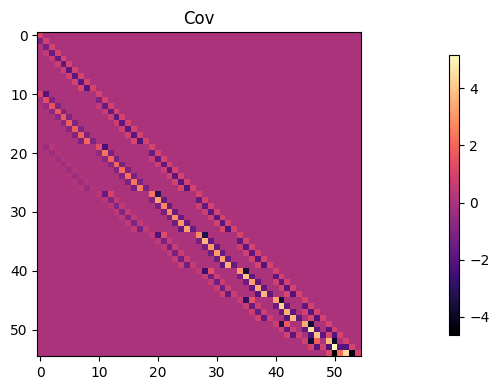

In [16]:
fig, axs = plt.subplots(1, 1, figsize=(5,4))

im = axs.imshow(P_AI_block,cmap='magma')#,norm=matplotlib.colors.SymLogNorm(0.01))
axs.set_title("Cov")
cbar_ax = fig.add_axes([1., 0.15, 0.02, 0.7])
fig.colorbar(im,cax=cbar_ax)

In [17]:
# Create a PrimaryHDU object
hdu = fits.PrimaryHDU(P_AI_block)
# Create an HDU list and append the PrimaryHDU
hdul = fits.HDUList([hdu])
# Specify the FITS filename
fits_filename = "Pai_55x55.fits"
# Write the HDU list to the FITS file
hdul.writeto(fits_filename, overwrite=True)

In [18]:
data_francis = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, \
                 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\
                [-1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,\
                 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],\
                [0.154938, -1.15494, 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., \
                 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, \
                 0, 0, 0, 0, 0, 0], [0, 0.523928, -1.52393, 1, 0, 0, 0, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., \
                 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,\
                 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0.658851, -1.65885, 1, 0, 0, 0, 0, 0, 0, 0., 0., 0, 0, \
                 0, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0, 0, 0,\
                 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0.741072, -1.74107, 1, 0, 0, 0, 0, 0, 0, 0., \
                 0., 0, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,\
                 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0.800322, -1.80032, 1, 0, 0, 0, 0, 0,\
                 0, 0., 0., 0, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0., 0., 0., 0., 0., 0., \
                 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0.859687, -1.85969, 1, 0, 0, \
                 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0., 0., 0, 0, 0,\
                 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0.932728, -1.93273, 1, 0, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0., 0., 0, 0, 0, 0., 0., 0, 0, 0., 0., 0., 0., 0., 0., 0., 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 1.10424, -2.10424, 1, 0, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0., 0., 0, 0, 0, 0., 0., 0, 0, 0., 0., 0, 0., 0., 0., 0., 0., 0], [1., -2., 0., 0., 0., 0., 0., 0., 0., 0., 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [-0.154938, 1.30988, -1., 0., 0., 0., 0., 0., 0., 0., -1.15494, 1., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0., -0.523928, 1.52393, -1., 0., 0., 0., 0., 0., 0., 0.523928, -1.52393, 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0., 0., -0.658851, 1.65885, -1., 0., 0., 0., 0., 0., 0, 0.658851, -1.65885, 1, 0, 0, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0., 0., 0., -0.741072, 1.74107, -1., 0., 0., 0., 0., 0, 0, 0.741072, -1.74107, 1, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0., 0., 0., 0., -0.800322, 1.80032, -1., 0., 0., 0., 0, 0, 0, 0.800322, -1.80032, 1, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0., 0., 0., 0., 0., -0.859687, 1.85969, -1., 0., 0., 0, 0, 0, 0, 0.859687, -1.85969, 1, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0., 0., 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0], [0., 0., 0., 0., 0., 0., -0.932728, 1.93273, -1., 0., 0, 0, 0, 0, 0, 0.932728, -1.93273, 1, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0., 0., 0, 0, 0, 0., 0., 0, 0, 0., 0., 0., 0., 0., 0., 0., 0, 0, 0], [0., 0., 0., 0., 0., 0., 0., -1.10424, 2.10424, -1., 0, 0, 0, 0, 0, 0, 1.10424, -2.10424, 1, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0., 0., 0, 0, 0, 0., 0., 0, 0, 0., 0., 0, 0., 0., 0., 0., 0., 0], [0.0240058, -0.357888, 0.309876, 0., 0., 0., 0., 0., 0., 0., 1.33388, -2.30988, 0., 0., 0., 0., 0., 0., 0., 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0., 0.0811763, -0.236114, 0.154938, 0., 0., 0., 0., 0., 0., -0.605104, 2.28397, -1.15494, 0., 0., 0., 0., 0., 0., -1.52393, 1., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0., 0., 0.102081, -0.257019, 0.154938, 0., 0., 0., 0., 0., 0., -0.760932, 1.91587, -1.15494, 0., 0., 0., 0., 0., 0.658851, -1.65885, 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0., 0., 0., 0.11482, -0.269758, 0.154938, 0., 0., 0., 0., 0., 0., -0.855893, 2.01083, -1.15494, 0., 0., 0., 0., 0, 0.741072, -1.74107, 1, 0, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0., 0., 0., 0., 0.124, -0.278938, 0.154938, 0., 0., 0., 0., 0., 0., -0.924322, 2.07926, -1.15494, 0., 0., 0., 0, 0, 0.800322, -1.80032, 1, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0., 0., 0., 0., 0., 0.133198, -0.288136, 0.154938, 0., 0., 0., 0., 0., 0., -0.992885, 2.14782, -1.15494, 0., 0., 0, 0, 0, 0.859687, -1.85969, 1, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0., 0., 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0], [0., 0., 0., 0., 0., 0., 0.144515, -0.299453, 0.154938, 0., 0., 0., 0., 0., 0., -1.07724, 2.23218, -1.15494, 0., 0, 0, 0, 0, 0.932728, -1.93273, 1, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0., 0., 0, 0, 0, 0., 0., 0, 0, 0., 0., 0., 0., 0., 0., 0., 0, 0, 0], [0., 0., 0., 0., 0., 0., 0., 0.171089, -0.326027, 0.154938, 0., 0., 0., 0., 0., 0., -1.27533, 2.43027, -1.15494, 0, 0, 0, 0, 0, 1.10424, -2.10424, 1, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0., 0., 0, 0, 0, 0., 0., 0, 0, 0., 0., 0, 0., 0., 0., 0., 0., 0], [0, 0., 0., 0, 0, 0, 0, 0, 0, 0, 0.2745, -1.59686, 1.04786, 0., 0., 0., 0., 0., 0., 2.32236, -3.04786, 0., 0., 0., 0., 0., 0., 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0., 0., 0., 0, 0, 0, 0, 0, 0, 0., 0.34519, -0.869118, 0.523928, 0., 0., 0., 0., 0., -1.00404, 3.18682, -1.52393, 0., 0., 0., 0., 0., -1.65885, 1., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0., 0., 0., 0., 0, 0, 0, 0, 0, 0., 0., 0.388268, -0.912196, 0.523928, 0., 0., 0., 0., 0., -1.12934, 2.65327, -1.52393, 0., 0., 0., 0., 0.741072, -1.74107, 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0., 0., 0, 0., 0., 0, 0, 0, 0, 0., 0., 0., 0.419311, -0.943239, 0.523928, 0., 0., 0., 0., 0., -1.21963, 2.74356, -1.52393, 0., 0., 0., 0, 0.800322, -1.80032, 1, 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0., 0., 0, 0, 0., 0., 0, 0, 0, 0., 0., 0., 0., 0.450414, -0.974341, 0.523928, 0., 0., 0., 0., 0., -1.3101, 2.83403, -1.52393, 0., 0., 0, 0, 0.859687, -1.85969, 1, 0, 0, 0, 0., 0., 0, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0], [0, 0., 0., 0, 0, 0, 0., 0., 0, 0, 0., 0., 0., 0., 0., 0.488682, -1.01261, 0.523928, 0., 0., 0., 0., 0., -1.42141, 2.94534, -1.52393, 0., 0, 0, 0, 0.932728, -1.93273, 1, 0, 0, 0, 0., 0., 0, 0, 0, 0., 0., 0, 0, 0., 0., 0., 0., 0., 0., 0., 0, 0, 0], [0, 0., 0., 0, 0, 0, 0, 0., 0., 0, 0., 0., 0., 0., 0., 0., 0.578541, -1.10247, 0.523928, 0., 0., 0., 0., 0., -1.68278, 3.20671, -1.52393, 0, 0, 0, 0, 1.10424, -2.10424, 1, 0, 0, 0, 0., 0., 0, 0, 0, 0., 0., 0, 0, 0., 0., 0, 0., 0., 0., 0., 0., 0], [0, 0, 0., 0., 0, 0, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0, 0.434084, -2.18587, 1.3177, 0., 0., 0., 0., 0., 2.75179, -3.3177, 0., 0., 0., 0., 0., 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0., 0., 0., 0, 0, 0, 0, 0, 0, 0., 0., 0., 0, 0, 0, 0, 0, 0., 0.488256, -1.14711, 0.658851, 0., 0., 0., 0., -1.22933, 3.62925, -1.65885, 0., 0., 0., 0., -1.74107, 1., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0., 0., 0., 0., 0, 0, 0, 0, 0, 0., 0., 0., 0., 0, 0, 0, 0, 0., 0., 0.527293, -1.18614, 0.658851, 0., 0., 0., 0., -1.32761, 2.98647, -1.65885, 0., 0., 0., 0.800322, -1.80032, 1., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0., 0., 0, 0., 0., 0, 0, 0, 0, 0., 0., 0, 0., 0., 0, 0, 0, 0., 0., 0., 0.566405, -1.22526, 0.658851, 0., 0., 0., 0., -1.42609, 3.08494, -1.65885, 0., 0., 0, 0.859687, -1.85969, 1, 0, 0, 0., 0., 0., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0], [0, 0, 0., 0., 0, 0, 0., 0., 0, 0, 0, 0., 0., 0, 0, 0., 0., 0, 0, 0., 0., 0., 0., 0.614529, -1.27338, 0.658851, 0., 0., 0., 0., -1.54726, 3.20611, -1.65885, 0., 0, 0, 0.932728, -1.93273, 1, 0, 0, 0., 0., 0, 0, 0., 0., 0., 0., 0., 0., 0., 0, 0, 0], [0, 0, 0., 0., 0, 0, 0, 0., 0., 0, 0, 0., 0., 0, 0, 0, 0., 0., 0, 0., 0., 0., 0., 0., 0.727528, -1.38638, 0.658851, 0., 0., 0., 0., -1.83177, 3.49062, -1.65885, 0, 0, 0, 1.10424, -2.10424, 1, 0, 0, 0., 0., 0, 0, 0., 0., 0, 0., 0., 0., 0., 0., 0], [0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0.549188, -2.58052, 1.48214, 0., 0., 0., 0., 3.03133, -3.48214, 0., 0., 0., 0., 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0., 0., 0., 0, 0, 0, 0, 0, 0, 0., 0., 0., 0, 0, 0, 0, 0, 0., 0., 0., 0, 0, 0, 0, 0., 0.593097, -1.33417, 0.741072, 0., 0., 0., -1.39342, 3.93481, -1.74107, 0., 0., 0., -1.80032, 1., 0., 0., 0., 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0., 0., 0., 0., 0, 0, 0, 0, 0, 0., 0., 0., 0., 0, 0, 0, 0, 0., 0., 0., 0., 0, 0, 0, 0., 0., 0.63709, -1.37816, 0.741072, 0., 0., 0., -1.49678, 3.23785, -1.74107, 0., 0., 0.859687, -1.85969, 1., 0., 0., 0., 0., 0., 0., 0, 0, 0, 0, 0, 0], [0, 0, 0, 0., 0., 0, 0., 0., 0, 0, 0, 0, 0., 0., 0, 0., 0., 0, 0, 0, 0., 0., 0, 0., 0., 0, 0, 0., 0., 0., 0.691219, -1.43229, 0.741072, 0., 0., 0., -1.62395, 3.36502, -1.74107, 0., 0, 0.932728, -1.93273, 1, 0, 0., 0., 0., 0., 0., 0., 0., 0, 0, 0], [0, 0, 0, 0., 0., 0, 0, 0., 0., 0, 0, 0, 0., 0., 0, 0, 0., 0., 0, 0, 0., 0., 0, 0, 0., 0., 0, 0., 0., 0., 0., 0.818321, -1.55939, 0.741072, 0., 0., 0., -1.92256, 3.66363, -1.74107, 0, 0, 1.10424, -2.10424, 1, 0, 0., 0., 0, 0., 0., 0., 0., 0., 0], [0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0.640515, -2.88167, 1.60064, 0., 0., 0., 3.24116, -3.60064, 0., 0., 0., 1, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0., 0., 0., 0, 0, 0, 0, 0, 0, 0., 0., 0., 0, 0, 0, 0, 0, 0., 0., 0., 0, 0, 0, 0, 0., 0., 0., 0, 0, 0, 0., 0.688026, -1.48835, 0.800322, 0., 0., -1.54771, 4.20772, -1.80032, 0., 0., -1.85969, 1., 0., 0., 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0., 0., 0., 0., 0, 0, 0, 0, 0, 0., 0., 0., 0., 0, 0, 0, 0, 0., 0., 0., 0., 0, 0, 0, 0., 0., 0., 0., 0, 0, 0., 0., 0.746483, -1.54681, 0.800322, 0., 0., -1.67921, 3.47953, -1.80032, 0., 0.932728, -1.93273, 1., 0., 0., 0., 0., 0, 0, 0], [0, 0, 0, 0, 0., 0., 0, 0., 0., 0, 0, 0, 0, 0., 0., 0, 0., 0., 0, 0, 0, 0., 0., 0, 0., 0., 0, 0, 0., 0., 0, 0., 0., 0, 0., 0., 0., 0.883746, -1.68407, 0.800322, 0., 0., -1.98799, 3.78831, -1.80032, 0, 1.10424, -2.10424, 1, 0., 0., 0., 0., 0., 0], [0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0., 0., 0, 0, 0, 0.739062, -3.1975, 1.71937, 0., 0., 3.45844, -3.71937, 0., 0., 1, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0., 0., 0., 0, 0, 0, 0, 0, 0, 0., 0., 0., 0, 0, 0, 0, 0, 0., 0., 0., 0, 0, 0, 0, 0., 0., 0., 0, 0, 0, 0., 0., 0., 0, 0, 0., 0.801855, -1.66154, 0.859687, 0., -1.73458, 4.527, -1.85969, 0., -1.93273, 1., 0., 0, 0, 0], [0, 0, 0, 0, 0, 0., 0., 0., 0., 0, 0, 0, 0, 0, 0., 0., 0., 0., 0, 0, 0, 0, 0., 0., 0., 0., 0, 0, 0, 0., 0., 0., 0., 0, 0, 0., 0., 0., 0., 0, 0., 0., 0.949299, -1.80899, 0.859687, 0., -2.05354, 3.91322, -1.85969, 1.10424, -2.10424, 1., 0., 0., 0], [0, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0., 0., 0, 0, 0, 0., 0., 0, 0, 0.869982, -3.60542, 1.86546, 0., 3.73544, -3.86546, 0., 1, 0, 0], [0, 0, 0, 0, 0, 0, 0., 0., 0., 0, 0, 0, 0, 0, 0, 0., 0., 0., 0, 0, 0, 0, 0, 0., 0., 0., 0, 0, 0, 0, 0., 0., 0., 0, 0, 0, 0., 0., 0., 0, 0, 0., 0., 0., 0, 0., 1.02995, -1.96268, 0.932728, -2.13419, 5.17116, -1.93273, -2.10424, 1., 0], [0, 0, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0, 0., 0., 0, 0, 0, 0, 0., 0., 0, 0, 0, 0., 0., 0, 0, 0., 0., 0, 1.21934, -4.64716, 2.20848, 4.42782, -4.20848, 1]]

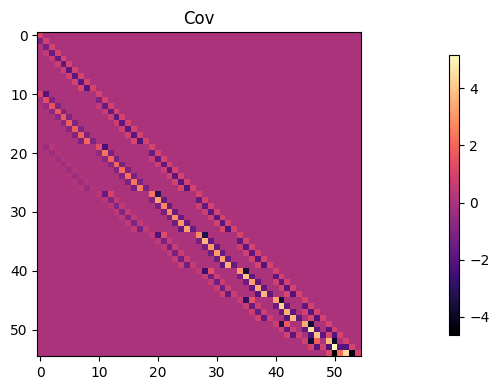

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(5,4))

im = axs.imshow(P_AI_block,cmap='magma')#,norm=matplotlib.colors.SymLogNorm(0.01))
axs.set_title("Cov")
cbar_ax = fig.add_axes([1., 0.15, 0.02, 0.7])
fig.colorbar(im,cax=cbar_ax)

### Calculate $P_A^{~~I}$

In [20]:
n_theta = 20
ntomoindex = int(ntomobin*(1+ntomobin)/2)
n_xi = n_theta*ntomoindex
n_P_AI = 2*n_theta*ntomoindex
P_AI = np.zeros((n_P_AI,n_P_AI))
ntomoindex,n_P_AI/2

(55, 1100.0)

In [21]:
for itheta in range(n_theta):
    i = itheta*ntomoindex
    #print(itheta,itheta+ntomoindex)
    #print(n_theta*ntomoindex+itheta,n_theta*ntomoindex+itheta+55)
    P_AI[i:(i+ntomoindex),i:(i+ntomoindex)] = P_AI_block
    P_AI[n_xi+i:(n_xi+i+ntomoindex),n_xi+i:(n_xi+i+ntomoindex)] = P_AI_block

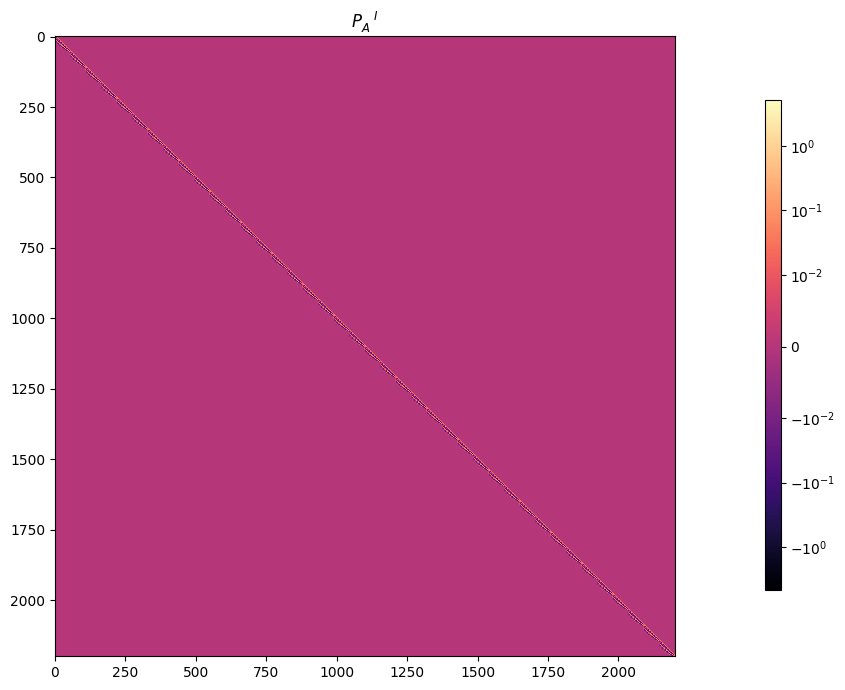

In [23]:
fig, axs = plt.subplots(1, 1, figsize=(8,7))

im = axs.imshow(P_AI,cmap='magma',norm=matplotlib.colors.SymLogNorm(0.01))
axs.set_title("$P_A^{~~~I}$")
cbar_ax = fig.add_axes([1., 0.15, 0.02, 0.7])
fig.colorbar(im,cax=cbar_ax)

### Make $w_i(z)$ and $w_a(z)$ kernel plots

In [24]:
def kernel_int(zp,z,n_of_z_interp):
    chi_of_zp = (cosmo.comoving_distance(zp)/(cst.c/cosmo.H0)).cgs
    chi_of_z = (cosmo.comoving_distance(z)/(cst.c/cosmo.H0)).cgs
    kernel_int = (1+z)*n_of_z_interp(zp)*(chi_of_zp-chi_of_z)*chi_of_z/chi_of_zp
    return kernel_int

def kernel(z,n_of_z_interp):
    zpmin = z
    zpmax = 3.
    result, error = fixed_quad(kernel_int, zpmin, zpmax, args=(z,n_of_z_interp),n=10000)
    return result

vectorized_kernel = np.vectorize(kernel, excluded=['n_of_z_interp'])

0
1
2
3
4
5
6
7
8
9


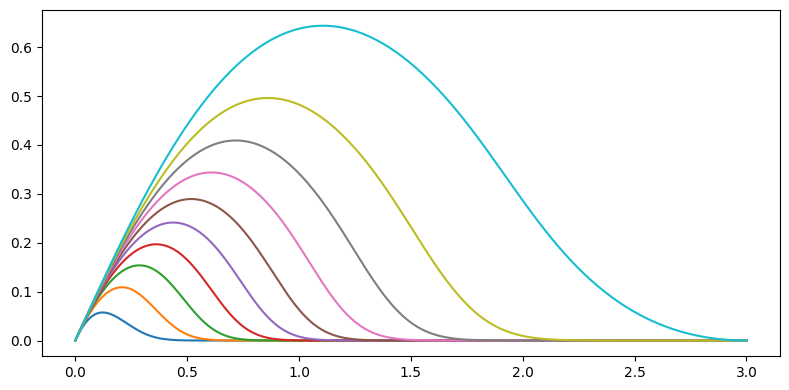

In [25]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

n_z_sample = 200
z_sample = np.linspace(0, 3, n_z_sample)
w_i_table = np.zeros((n_z_sample,ntomobin))

for i in range(ntomobin):
    print(i)
    z_list = nz_table[:,0]
    f_list = nz_table[:,i+1]
    n_of_z_interp = interp1d(z_list, f_list, kind='quadratic',fill_value='extrapolate')
    
    w_i_table[:,i] = vectorized_kernel(z_sample,n_of_z_interp)
    
    plt.plot(z_sample,w_i_table[:,i])   

In [26]:
w_a_table = np.zeros((n_z_sample,ntomobin))
for a in range(ntomobin):
    for i in range(ntomobin):
        #print(a,i,p_a_i[a,i])
        w_a_table[:,a] = w_a_table[:,a]+p_a_i[a,i]*w_i_table[:,i]

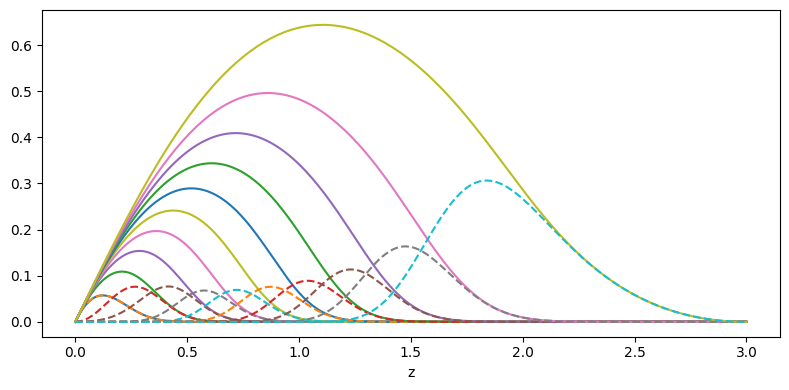

In [27]:
fig, axs = plt.subplots(1, 1, figsize=(8, 4))

for a in range(ntomobin):
    plt.plot(z_sample,w_i_table[:,a])   
    plt.plot(z_sample,w_a_table[:,a],linestyle='--')
    plt.xlabel('z')
    #plt.yscale('log')
    #plt.ylim([1e-18,1e-10])

## Read CCL and BNT ordering covariance matrix

In [31]:
hdu1 = fits.open('/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/covariance_cosmocov_CCL_10zbins_20theta.fits')
covmat_CCL = hdu1[0].data
hdu1.close()
cov_inv_CCL = np.linalg.inv(covmat_CCL)
cov_inv_CCL @ covmat_CCL

array([[ 1.00000000e+00,  4.46412833e-20, -2.80623091e-20, ...,
        -4.18023994e-20, -2.79653221e-20,  6.95493459e-20],
       [-1.52921087e-19,  1.00000000e+00, -7.53855187e-20, ...,
        -5.72408984e-21, -5.75585357e-20, -9.99498878e-20],
       [ 2.41031952e-19,  1.27773762e-19,  1.00000000e+00, ...,
         1.94089659e-20,  5.16425400e-20,  1.15725876e-19],
       ...,
       [ 6.15826834e-17,  6.93889390e-17,  7.97972799e-17, ...,
         1.00000000e+00,  1.11022302e-15,  1.38777878e-15],
       [-2.94902991e-17, -3.46944695e-18, -3.29597460e-17, ...,
        -2.22044605e-16,  1.00000000e+00,  0.00000000e+00],
       [-4.33680869e-17, -7.80625564e-17, -1.11022302e-16, ...,
         2.22044605e-16, -4.44089210e-16,  1.00000000e+00]])

In [32]:
hdu2 = fits.open('/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/covariance_cosmocov_BNT_10zbins_20theta.fits')
covmat_BNT_order = hdu2[0].data

#. apply the BNT transfor to the BNT ordered covariance matrix
#covmat_BNT = np.einsum('ai,bj,ij->ab',P_AI,P_AI,covmat_BNT_order)
covmat_BNT = P_AI @ np.transpose(P_AI @ np.transpose(covmat_BNT_order))

In [33]:
cov_inv_BNT = np.linalg.inv(covmat_BNT)
cov_inv_BNT @ covmat_BNT

array([[ 1.00000000e+00, -3.65530380e-10,  5.27667485e-10, ...,
         6.25559828e-14, -2.40112154e-14, -6.68441598e-15],
       [ 3.67521266e-10,  9.99999999e-01,  1.30589384e-09, ...,
         1.51484012e-13, -5.11742698e-14, -2.38066398e-14],
       [ 4.89053526e-10, -1.23816072e-09,  1.00000000e+00, ...,
         1.84249479e-13, -4.96150597e-14, -4.67543671e-14],
       ...,
       [-3.02313730e-13, -1.50809920e-13,  1.23116795e-12, ...,
         1.00000000e+00, -6.14786000e-14,  1.40568113e-13],
       [-1.93806776e-13, -9.20583054e-14,  7.54632468e-13, ...,
         3.18370330e-13,  1.00000000e+00, -6.55031585e-15],
       [-3.12866053e-14, -1.33660444e-14,  1.13796125e-13, ...,
         3.52834081e-14,  5.21648696e-14,  1.00000000e+00]])

### Calculate eigenvalues

In [34]:
U_ccl, S_ccl, Vh_ccl = sp.linalg.svd(covmat_CCL , full_matrices=True)
S_ccl_inv = 1/S_ccl
inverse_CCL = np.dot(Vh_ccl.T, np.dot(np.diag(S_ccl_inv), U_ccl.T))

In [35]:
U_bnt, S_bnt, Vh_bnt = sp.linalg.svd(covmat_BNT, full_matrices=True)
S_bnt_inv = 1/S_bnt
inverse_BNT = np.dot(Vh_bnt.T, np.dot(np.diag(S_bnt_inv), U_bnt.T))

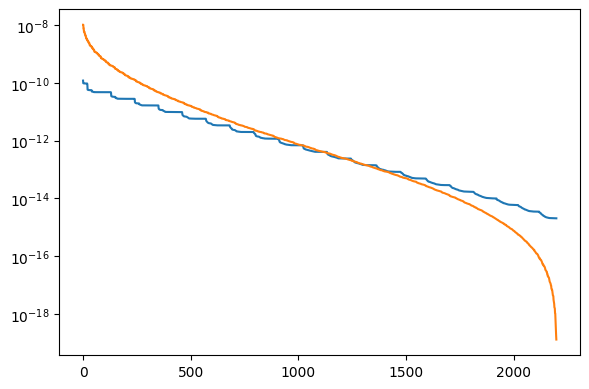

In [36]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

plt.plot(S_ccl)
plt.plot(S_bnt)
plt.yscale('log')

## Read CCL and BNT data vectors

In [37]:
data_ccl = np.load('/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/data_vector_CCL_10zbins_20theta.npy')

In [38]:
data_bnt_ordering = np.load('/Users/waerbeke/Documents/RESEARCH/cosmocov/CosmoCov-master/covs/data_vector_BNT_10zbins_20theta.npy')
data_bnt = P_AI @ data_bnt_ordering

## Calculate $\chi^2$ using CCL and BNT matrices and model vectors

In [39]:
data_ccl @ cov_inv_CCL @ data_ccl

247189.44876371452

In [40]:
data_bnt_ordering @ np.linalg.inv(covmat_BNT_order) @ data_bnt_ordering

247189.44876371435

In [41]:
data_bnt @ cov_inv_BNT @ data_bnt

247189.44876106468

### $\chi^2$ tests

In [131]:
ntheta = 10 #(two binnings choices both exists 35 or 10, 35 one is more stable)
#covariance = np.load('data_vec_covmat/BNT_covmat_LSST_'+str(ntheta*110)+'_enz.npy')/np.sqrt(180)
covariance = np.load('data_vec_covmat/xipm_LSST_cov_'+str(110*ntheta)+'_allLoS.npy')#/np.sqrt(180)
icov = np.linalg.pinv(covariance,hermitian=True)
theta = np.loadtxt('data_vec_covmat/thetas'+str(ntheta)+'.dat')/60.0
mock_ob_xip = np.load('data_vec_covmat/xip_LSST_SLICS_nf'+str(ntheta)+'.npy') # in the format of (10,10,ntheta)
mock_ob_xim = np.load('data_vec_covmat/xim_LSST_SLICS_nf'+str(ntheta)+'.npy') # in the format of (10,10,ntheta)
covariance.shape,theta.min()

((1100, 1100), 0.05245522549142363)

In [18]:
mock_ob_xip[1,2,:],mock_ob_xip[2,1,:]

(array([1.91414779e-06, 2.19511990e-06, 2.21227511e-06, 1.97093707e-06,
        1.57389392e-06, 1.14815450e-06, 7.94223100e-07, 5.47429471e-07,
        3.80513093e-07, 2.74280935e-07]),
 array([1.91414779e-06, 2.19511990e-06, 2.21227511e-06, 1.97093707e-06,
        1.57389392e-06, 1.14815450e-06, 7.94223100e-07, 5.47429471e-07,
        3.80513093e-07, 2.74280935e-07]))

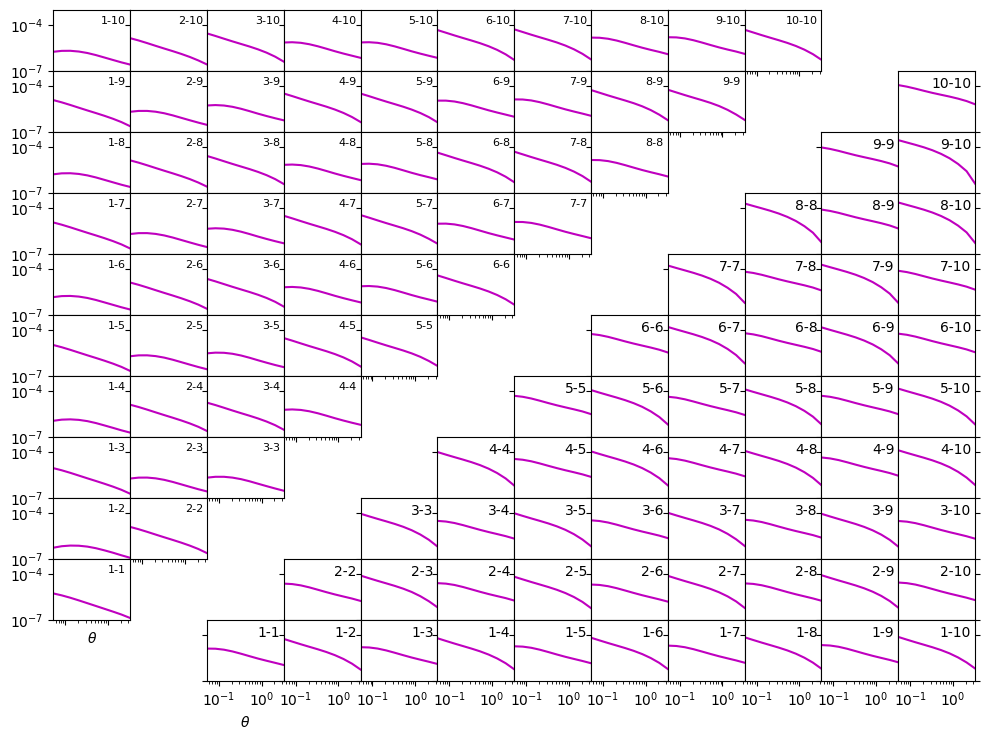

In [19]:
ntomobin = 10
xvalues = theta

text_width = 10
#column_width = 256.0748/72
tick_spacing = 2
fig,axes= plt.subplots(ntomobin+1,ntomobin+2,figsize=(text_width, text_width*0.75),gridspec_kw={'hspace': 0, 'wspace': 0})

# Blank out the empty cells
for i in range(ntomobin+1):
    blankgrid=ntomobin-i+1
    axes[i,blankgrid].set_visible(False)
    axes[i,blankgrid-1].set_visible(False)

# plots range
xmin,xmax = xvalues.min(),xvalues.max()
ymin,ymax = [1e-7,1e-3]

for iz in range(1,ntomobin+1):
    for jz in range(iz,ntomobin+1):

        # tomographic bin combination
        tomochar='%s-%s'%(iz,jz)
        
        # -------- TOP SUBPLOTS -------
        # find tomographic grid cell in top subplots
        gridcell_x_top=(iz-1)
        gridcell_y_top=(ntomobin-jz)
        ax=axes[gridcell_y_top,gridcell_x_top]
        
        # load yvalues
        yvalues = mock_ob_xip[iz-1,jz-1,:]
        # plot (xvalues,yvalues)
        ax.plot(xvalues,yvalues,color='m',linewidth=1.5)
        
        # only label the subplots at the edges
        ax.label_outer()
        # and then override for the autocorrelations
        if iz==jz:
            ax.xaxis.tick_bottom()
            if iz==1:
                ax.set_xlabel('$\\theta$')
        
        # add the tomographic bin combination
        ax.annotate(tomochar, xy=(0.95,0.9),xycoords='axes fraction',size=8, ha='right', va='top')
        ax.axhline(y=0, color='black', ls=':')
        
        # set the limits of the plot
        ax.set_xscale('log')
        ax.set_xlim(xmin,xmax)
        ax.set_yscale('log')
        ax.set_ylim(ymin,ymax)
        
        # -------- BOTTOM SUBPLOTS -------
        # find tomographic grid cell in bottom subplots
        gridcell_x_bottom=(jz+1)
        gridcell_y_bottom=(ntomobin+1-iz)
        ax=axes[gridcell_y_bottom,gridcell_x_bottom]
        # load yvalues
        yvalues = mock_ob_xim[iz-1,jz-1,:]
        # plot (xvalues,yvalues)
        ax.plot(xvalues,yvalues,color='m',linewidth=1.5)
        
        # only label the subplots at the edges
        ax.label_outer()
        # and then override for the bin 5 left column
        if jz==ntomobin:
            ax.yaxis.tick_right()
        if ((iz==1) and (jz==1)):
            ax.set_xlabel('$\\theta$')

        # add the tomographic bin combination and a horizontal line
        ax.annotate(tomochar, xy=(0.95,0.9),xycoords='axes fraction',size=10, ha='right', va='top')
        ax.axhline(y=0, color='black', ls=':')
        
        # set the limits of the plot
        ax.set_xscale('log')
        ax.set_xlim(xmin,xmax)
        ax.set_yscale('log')
        ax.set_ylim(ymin,ymax)

### Create $ij$ data vector

In [20]:
ntheta = theta.size
xi_vec_size = ntomobin*(ntomobin+1)*ntheta

xi_vec = np.zeros(xi_vec_size)
xi_vec_size

1100

In [21]:
icpt = 0
n_xipm = np.int16(ntomobin*(ntomobin+1)*ntheta/2)
print(n_xipm)

for iz in range(1,ntomobin+1):
    for jz in range(iz,ntomobin+1):

        # tomographic bin combination
        tomochar='%s-%s'%(iz,jz)

        #  find indices in xi_vec_size
        n1_xip = icpt*ntheta
        n2_xip = (icpt+1)*ntheta-1
        n1_xim = n_xipm+icpt*ntheta
        n2_xim = n_xipm+(icpt+1)*ntheta-1
        
        # load yvalues
        xi_vec[n1_xip:n2_xip+1] = mock_ob_xip[iz-1,jz-1,:]
        xi_vec[n1_xim:n2_xim+1] = mock_ob_xim[iz-1,jz-1,:]
                
        icpt += 1

550


### Extract one scale from data vector and covariance matrix

#### From data vector

In [29]:
iscale = 0
xi_vec_custom = np.zeros(ntomobin*(ntomobin+1))


icpt = 0
for iz in range(1,ntomobin+1):
    for jz in range(iz,ntomobin+1):
        #  find indices for xi+
        n1_xip = icpt*ntheta
        n2_xip = (icpt+1)*ntheta-1
        #print(iscale+n1_xip)
        icpt += 1
        
for iz in range(1,ntomobin+1):
    for jz in range(iz,ntomobin+1):
        #  find indices for xi-
        n1_xim = n_xipm+icpt*ntheta
        n2_xim = n_xipm+(icpt+1)*ntheta-1
        #print(iscale+n1_xim)
        icpt += 1

print(icpt)

110


In [132]:
U, S, Vh = sp.linalg.svd(covariance[0:550,0:550], full_matrices=True)
S_inv = 1/S #np.where(S > 1e-27, 1 / S, 0)
inverse_matrix = np.dot(Vh.T, np.dot(np.diag(S_inv), U.T))
unity = inverse_matrix @ covariance[0:550,0:550]

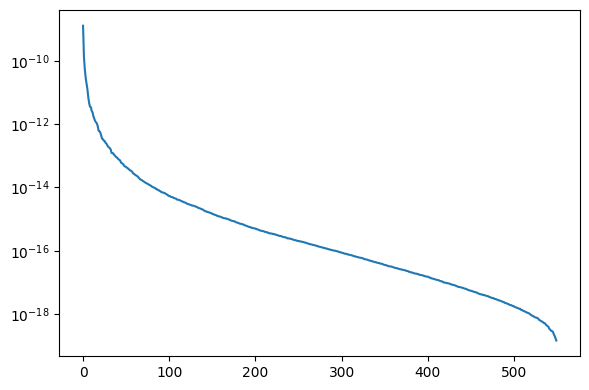

In [133]:
fig, axs = plt.subplots(1, 1, figsize=(6, 4))

plt.plot(S)
plt.yscale('log')

In [119]:
inverse_matrix = sp.linalg.inv(covariance)
unity = inverse_matrix @ covariance

In [134]:
pd.DataFrame(unity)

,0,1,2,3,4,5,6,7,8,9,...,540,541,542,543,544,545,546,547,548,549
0,1.000000e+00,2.755769e-10,-1.541139e-09,2.904926e-08,-7.053814e-09,1.395165e-09,-5.375682e-10,-1.785310e-10,-3.997627e-09,-4.996423e-09,...,-2.477464e-09,-3.419700e-10,2.657544e-09,1.773515e-09,3.612513e-09,5.697984e-10,3.409014e-09,5.714128e-09,5.647053e-09,1.959506e-09
1,8.039933e-10,1.000000e+00,6.870323e-09,-1.702756e-08,6.188202e-09,6.183654e-09,-1.505668e-09,-2.782144e-09,3.735977e-09,1.961070e-09,...,-3.201421e-10,-2.473826e-10,-2.779416e-09,-2.750312e-09,-5.289621e-09,-2.339220e-09,-9.094947e-10,-2.235538e-09,-6.466507e-10,-1.700442e-09
2,-1.900844e-10,1.432090e-08,1.000000e+00,-3.487094e-08,-9.737050e-09,-1.102171e-08,-1.044361e-08,1.788294e-10,-3.312323e-09,-1.428276e-09,...,3.824425e-09,-1.542503e-09,-4.656613e-10,-1.502485e-09,-6.912160e-10,-9.513315e-10,-1.925400e-09,-3.260084e-09,-1.945864e-09,9.126779e-10
3,9.331416e-10,-1.400076e-08,7.583367e-09,1.000000e+00,1.958233e-08,1.788976e-09,1.482431e-08,2.912202e-09,-2.239631e-10,3.359673e-09,...,-2.677552e-09,2.328306e-09,5.071342e-09,3.768946e-09,6.017217e-09,3.507012e-09,2.764864e-10,-1.546141e-09,-4.845788e-09,-5.566108e-10
4,8.658390e-10,2.606794e-08,-5.580659e-09,5.891707e-09,1.000000e+00,-7.527660e-09,1.406761e-09,-2.061483e-09,2.906120e-09,6.825587e-09,...,5.238689e-10,3.943569e-09,-2.823072e-09,7.530616e-10,-2.015440e-09,3.762125e-09,-5.865104e-10,1.950184e-09,2.008392e-09,-8.458301e-11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
545,-4.047251e-11,5.078391e-10,-1.755325e-10,5.854872e-11,2.534364e-10,1.020339e-10,2.265494e-10,-2.305001e-10,-1.161311e-10,-2.701199e-10,...,9.777068e-12,7.660717e-11,1.256240e-10,-3.410605e-11,7.844392e-12,1.000000e+00,1.123226e-10,1.032276e-10,1.509761e-10,9.322321e-12
546,2.455636e-11,-2.177330e-09,7.507879e-10,1.460648e-09,8.235475e-10,3.626610e-10,6.000391e-10,3.709602e-10,1.654143e-10,4.507683e-11,...,-1.455192e-10,-2.874003e-10,-5.456968e-11,2.910383e-11,1.455192e-11,-1.818989e-11,1.000000e+00,4.001777e-11,-6.912160e-11,-3.819878e-11
547,6.139089e-11,2.046363e-12,-2.834213e-10,-1.700300e-09,-5.768470e-10,3.416289e-11,-8.733423e-10,-1.023182e-11,2.675336e-10,3.779697e-10,...,3.292371e-10,2.009983e-10,-6.230039e-11,-1.350600e-10,-3.381615e-10,-1.471108e-10,-1.764420e-10,1.000000e+00,-1.045919e-11,6.397727e-11
548,-1.302851e-10,1.454964e-09,-3.822151e-10,-1.364242e-11,1.095941e-10,-3.915375e-10,5.479706e-11,1.182343e-11,-3.665264e-10,-3.560672e-10,...,-3.346941e-10,-2.091838e-10,6.002665e-11,-9.276846e-11,2.455636e-10,-6.912160e-11,4.183676e-11,-6.184564e-11,1.000000e+00,2.364686e-11


In [128]:
covariance.dtype

dtype('float64')

In [135]:
# Create a PrimaryHDU object
hdu = fits.PrimaryHDU(covariance.astype(np.float64))

# Create an HDU list and append the PrimaryHDU
hdul = fits.HDUList([hdu])

# Specify the FITS filename
fits_filename = "covariance.fits"

# Write the HDU list to the FITS file
hdul.writeto(fits_filename, overwrite=True)


### extract and transform data vector

In [20]:
V_i = 1e-5*Matrix(np.ones(10))
mock_ob_xip[0,0,0:2]

array([5.63763015e-06, 4.18819676e-06])

In [21]:
V_i = Matrix(mock_ob_xip[0,0,:])
Mat_p_a_i.multiply(V_i)

Matrix([
[ 5.63763015330292e-6],
[-1.44943338991238e-6],
[-1.00490161317355e-6],
[-3.01830680936826e-7],
[-2.91341205422832e-8],
[  5.9541405782976e-8],
[ 6.34141817036954e-8],
[ 6.08518293207659e-8],
[ 4.93302360736829e-8],
[ 5.02246548271626e-8]])

In [22]:
imax = 2
V_i = Matrix(mock_ob_xip[0,0,0:imax])
C_ij = Matrix(covariance[0:imax,0:imax])
(V_i.transpose().multiply(C_ij.inv())).dot(V_i)

29.6176738995632

In [23]:
V_a = Mat_p_a_i.multiply(V_i)
C_ab = Mat_p_a_i.multiply(Mat_p_a_i.multiply(C_ij))
(V_a.transpose().multiply(C_ab.inv())).dot(V_a)

ShapeError: Matrix size mismatch: (10, 10) * (2, 1).

((3850, 3850), 3850)

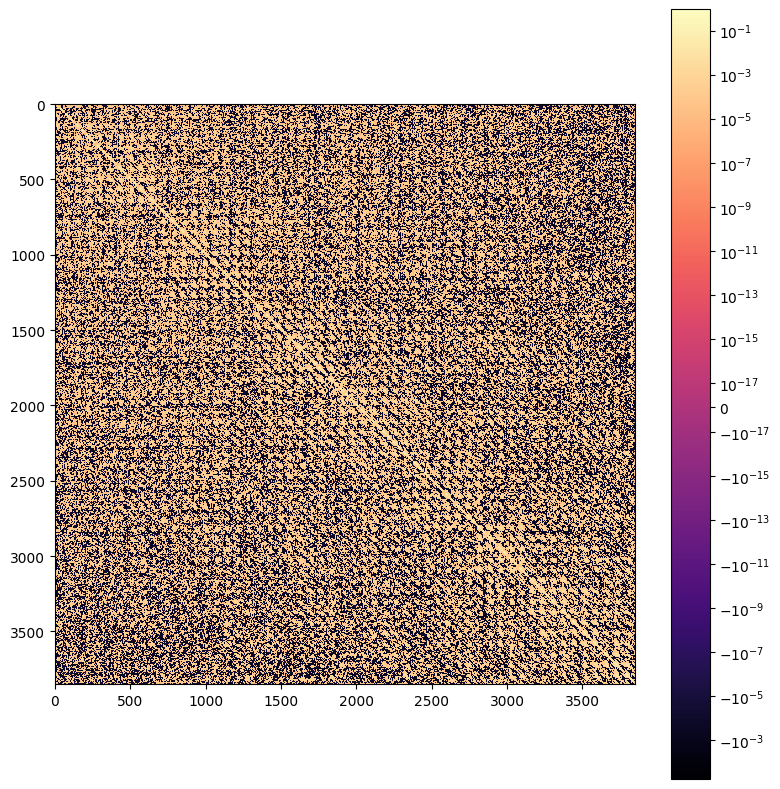

In [93]:
plt.imshow(unity,cmap='magma',norm=matplotlib.colors.SymLogNorm(1e-17))
plt.colorbar()
covariance.shape,35*110

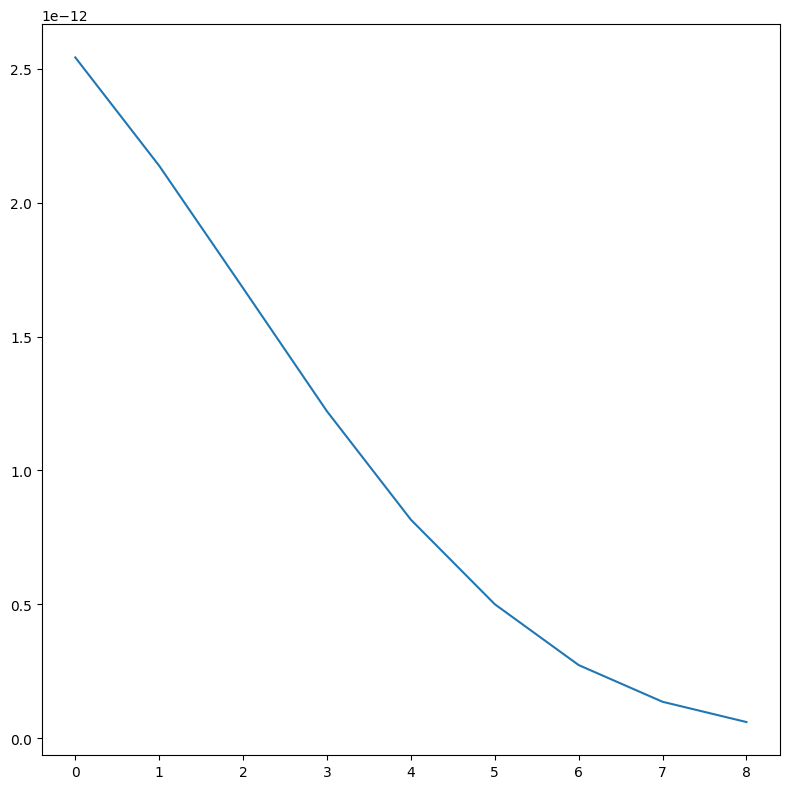

In [83]:
plt.plot(covariance[0:9,0])
#plt.xscale('log')